In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.auto import tqdm
from datasets import get_available_datasets
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

sns.set_style('whitegrid')
sns.set_context("talk")
pd.set_option('display.width', 2000)

## Helper Functions

In [3]:
def read_tensorboard_logs(path, tasks, datasets, methods, epsilons, hops, aggs, metrics=None):
    data = []
    if 'raw' in methods:
        configs = list(product(tasks, datasets, ['raw'], [0.0], hops, aggs))
        configs += list(product(tasks, datasets, set(methods) - {'raw'}, set(epsilons) - {0.0}, hops, aggs))
    else:
        configs = list(product(tasks, datasets, methods, epsilons, hops, aggs))
    
    for task, dataset, method, eps, k, agg in tqdm(configs):
        version_path = os.path.join(path, task, dataset, method, str(eps), str(k), agg)
        versions = os.listdir(version_path)
        
        for version in versions:
            event_path = os.path.join(version_path, version)
            output = subprocess.getoutput(f'find "{event_path}" -type f -name "*tfevents*"')
            event_file = output.splitlines()[-1]

            event_acc = EventAccumulator(event_file)
            event_acc.Reload()

            # eps_str = 'raw' if eps == 0.0 else str(int(eps))
            if metrics is None: 
                metrics = event_acc.scalars.Keys()
                
            for metric in metrics:
                if metric in event_acc.scalars.Keys():
                    scalars = event_acc.Scalars(metric)
                    for item in scalars:
                        if method == 'raw':
                            for fake_eps in epsilons:
                                data.append([
                                    task, dataset, method, fake_eps, k, agg, version, metric, item.step, item.value
                                ])
                        else:
                            data.append([task, dataset, method, eps, k, agg, version, metric, item.step, item.value])

    df = pd.DataFrame(data, columns=[
        'task', 'dataset', 'method', 'eps', 'hop', 'agg', 'version', 'metric', 'step', 'value'
    ])
    return df



def export_figure(path, df, x, y, hue, row, col, group):
    if not os.path.exists(path):
        os.makedirs(path)
    df = df.groupby([group, row, col, hue, x])[y].agg(['mean', np.std]).reset_index()
    df['filename'] = df[[group, row, col, hue]].apply(lambda row: '-'.join(row.astype(str)) + f'-{x}.txt', axis=1)
    df.groupby('filename').apply(
        lambda row: row[[x,'mean','std']].to_csv(
            os.path.join(path, row['filename'].unique().item()), 
            index=None, 
            sep=' '
        )
    )
    

# only to print latex code
def latex_output(df_results, base, pos=0):
    df_max = df_results.applymap(
        lambda x: float(x[:4])                   # considering the mean part
    ).groupby('Dataset').apply(
        lambda x: x - x.iloc[0]                 # calculate the diff between Raw method and others
    ).groupby('Dataset').apply(
        lambda x : x == x.iloc[1:].max()     # pick the results which are closer to Raw
    )

    df_max.loc[(slice(None), base), :] = False  # prevent making Raw results bold

    # make near optimal results bold
    df_bold = df_results.copy()
    df_bold[df_max] = df_bold[df_max].applymap(lambda x: '\\textbf{' + str(x) + '}')

    # print latex code
    cols = data.shape[1] + 2
    latex = df_bold.to_latex(escape=False)
    for line in latex.splitlines():
        if line.find(base + ' ') == -1:
            print(line)
        else:
            print('\\midrule')
            print(line)
            print('\\cmidrule{2-%d}' % cols)
#             print('\\midrule')

## Analysis of the utility-privacy trade-off

In [171]:
datasets = get_available_datasets()
epsilons = [0.5, 1.0, 2.0, 4.0]
metrics = ['test_acc']

data_dpgnn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['mbm'], 
    epsilons=epsilons,
    hops=[1,2,4,8,16,32,64],
    aggs=['mean'],
    metrics=metrics
)

data_gcn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['raw'], 
    epsilons=epsilons,
    hops=[1],
    aggs=['gcn'],
    metrics=metrics
)

data_gm = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['gm'], 
    epsilons=epsilons,
    hops=[1],
    aggs=['gcn'],
    metrics=metrics
)

In [172]:
names = {
    'raw': '1-GCN',
    'mbm': '2-DPGNN',
    'gm': '3-GCN+GM'
}
df_mean = data_dpgnn.groupby(['dataset', 'eps', 'hop'])['value'].mean().reset_index()
idx = df_mean.groupby(['dataset', 'eps'])['value'].transform(max) == df_mean['value']
df_max = df_mean[idx]
df_final = data_dpgnn.merge(df_max.drop(columns='value'), on=['dataset', 'eps', 'hop'], how='inner')
data = df_final.append(data_gcn, ignore_index=True).append(data_gm, ignore_index=True)
data = data.groupby(['dataset', 'method', 'eps']).agg({'value': ['mean', lambda x: np.std(x)]}).reset_index()
data = data.replace(names)
data['dataset'] = data['dataset'].str.title()
data.columns = ['Dataset', 'Method', '$\epsilon$', 'mean', 'std']
data['result'] = data[['mean', 'std']].apply(lambda row: '%.1f $\pm$ %.1f' % (row['mean']*100, row['std']*100), axis=1)
data = data.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$'])
data = data.unstack()
data = data.rename(index=lambda name: name[2:] if name[1] == '-' else name)
data
# latex_output(data, base='GCN')

result                                                
$\epsilon$                  0.5             1.0             2.0             4.0
Dataset  Method                                                                
Cora     GCN     81.3 $\pm$ 0.2  81.3 $\pm$ 0.2  81.3 $\pm$ 0.2  81.3 $\pm$ 0.2
         DPGNN   69.9 $\pm$ 1.4  70.1 $\pm$ 1.0  71.0 $\pm$ 5.1  73.5 $\pm$ 1.1
         GCN+GM  49.5 $\pm$ 1.8  49.1 $\pm$ 1.8  48.1 $\pm$ 2.3  49.3 $\pm$ 2.8
Elliptic GCN     94.2 $\pm$ 0.2  94.2 $\pm$ 0.2  94.2 $\pm$ 0.2  94.2 $\pm$ 0.2
         DPGNN   92.8 $\pm$ 0.2  92.6 $\pm$ 0.1  92.4 $\pm$ 0.2  92.4 $\pm$ 0.2
         GCN+GM  90.4 $\pm$ 0.0  90.4 $\pm$ 0.0  90.4 $\pm$ 0.0  90.4 $\pm$ 0.0
Facebook GCN     94.9 $\pm$ 0.1  94.9 $\pm$ 0.1  94.9 $\pm$ 0.1  94.9 $\pm$ 0.1
         DPGNN   93.5 $\pm$ 0.2  93.8 $\pm$ 0.3  94.1 $\pm$ 0.2  93.9 $\pm$ 0.2
         GCN+GM  86.4 $\pm$ 0.3  86.1 $\pm$ 0.3  86.2 $\pm$ 0.4  86.4 $\pm$ 0.5
Github   GCN     87.2 $\pm$ 0.0  87.2 $\pm$ 0.0  87.2 $\pm$ 0.0  87.2 $\pm$ 0.0
         DPGNN   85.3 $\pm$ 0.3  85.8 $\pm$ 0.4  86.1 $\pm$ 0.4  85.9 $\pm$ 0.4
         GCN+GM  77.8 $\pm$ 0.5  78.1 $\pm$ 0.5  78.3 $\pm$ 0.6  78.0 $\pm$ 0.5
Twitch   GCN     61.3 $\pm$ 0.2  61.3 $\pm$ 0.2  61.3 $\pm$ 0.2  61.3 $\pm$ 0.2
         DPGNN   57.2 $\pm$ 1.6  57.6 $\pm$ 0.9  58.3 $\pm$ 0.8  58.1 $\pm$ 0.6
         GCN+GM  55.2 $\pm$ 1.1  55.2 $\pm$ 1.5  54.8 $\pm$ 1.4  55.3 $\pm$ 1.7

## Studying the effect of KProp

In [169]:
epsilons = [1.0]
hops = [
    1, 
    2, 
    4, 
    8,
    16,
    32,
    64
]

data_dpgnn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['mbm'], 
    epsilons=epsilons,
    hops=hops,
    aggs=['mean'],
    metrics=metrics
)

data_gcn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['raw'], 
    epsilons=epsilons,
    hops=hops,
    aggs=['gcn'],
    metrics=metrics
)

data = data_dpgnn.append(data_gcn, ignore_index=True)

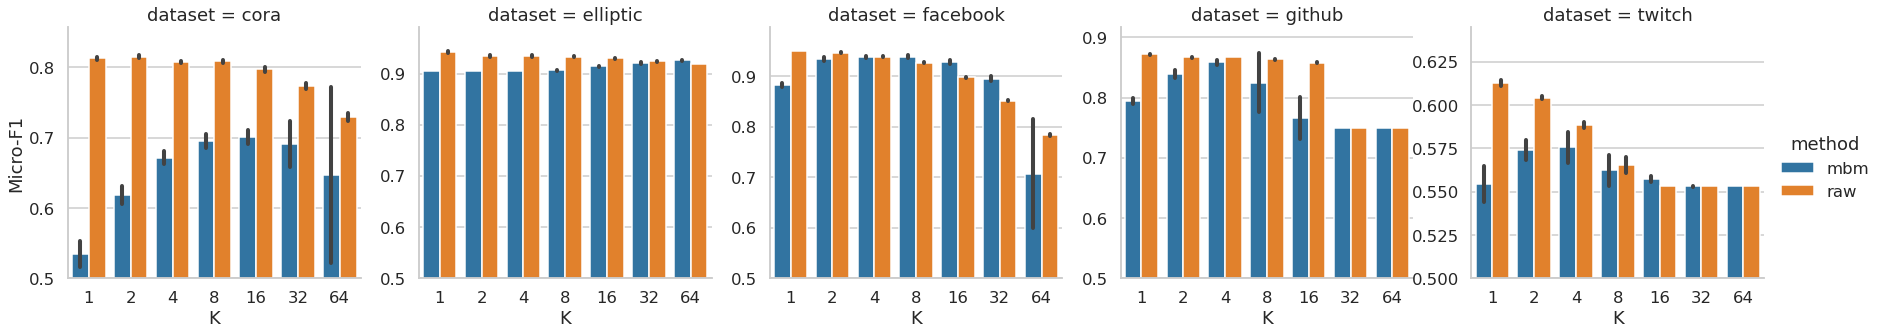

In [170]:
ax = sns.catplot(
    kind='bar', data=data, x='hop', y='value', hue='method', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set(ylim=0.5)
ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')
export_figure(path='figures', df=data, x='hop', y='value', hue='method', row='agg', col='dataset', group='task')

## Studying the effect of multi-bit mechanism

In [160]:
df_error = read_tensorboard_logs(
    path='results/', 
    tasks=['error'], 
    datasets=get_available_datasets(), 
    methods=['mbm', 'gm'], 
    epsilons=[0.5, 1.0, 2.0, 4.0], 
    hops=[1,2,4,8], 
    aggs=['mean'], 
    metrics=['mae']
)

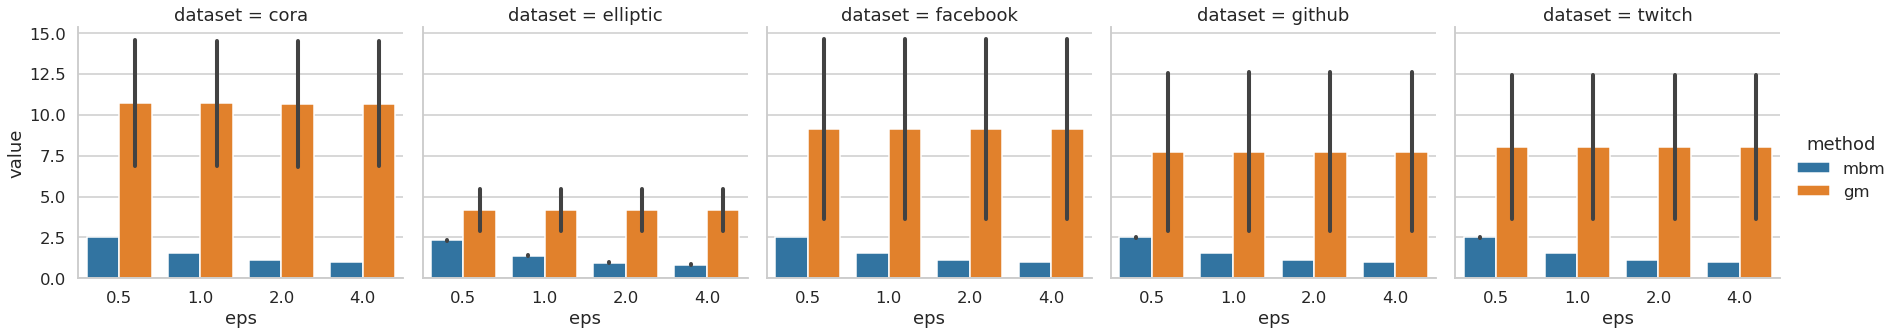

In [163]:
data = df_error[df_error['hop'] == 1]

ax = sns.catplot(
    data=data, kind='bar', x='eps', y='value', hue='method', col='dataset',
    facet_kws=dict(sharey=False, sharex=False), ci='sd'
)

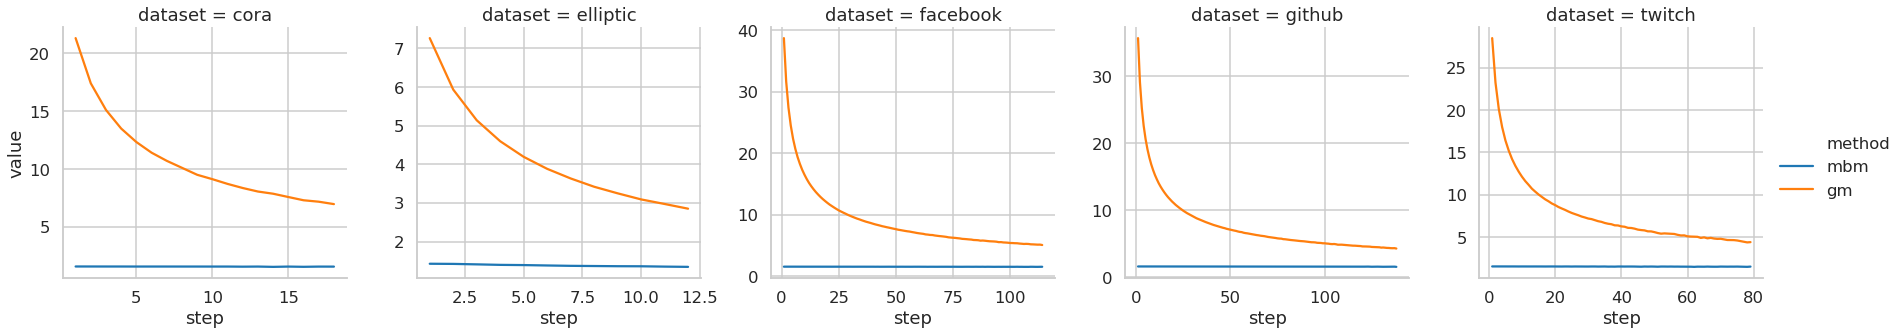

In [164]:
data = df_error[(df_error['hop'] == 1) & (df_error['eps'] == 1)]

ax = sns.relplot(
    data=data, kind='line', x='step', y='value', hue='method', col='dataset',
    facet_kws=dict(sharey=False, sharex=False), ci=None
)

## Analysis of the model convergence

In [7]:
data = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['mbm'], 
    epsilons=[0.5, 1.0, 2.0, 4.0],
    hops=[1],
    aggs=['mean'],
    metrics=['train_acc', 'val_acc']
)

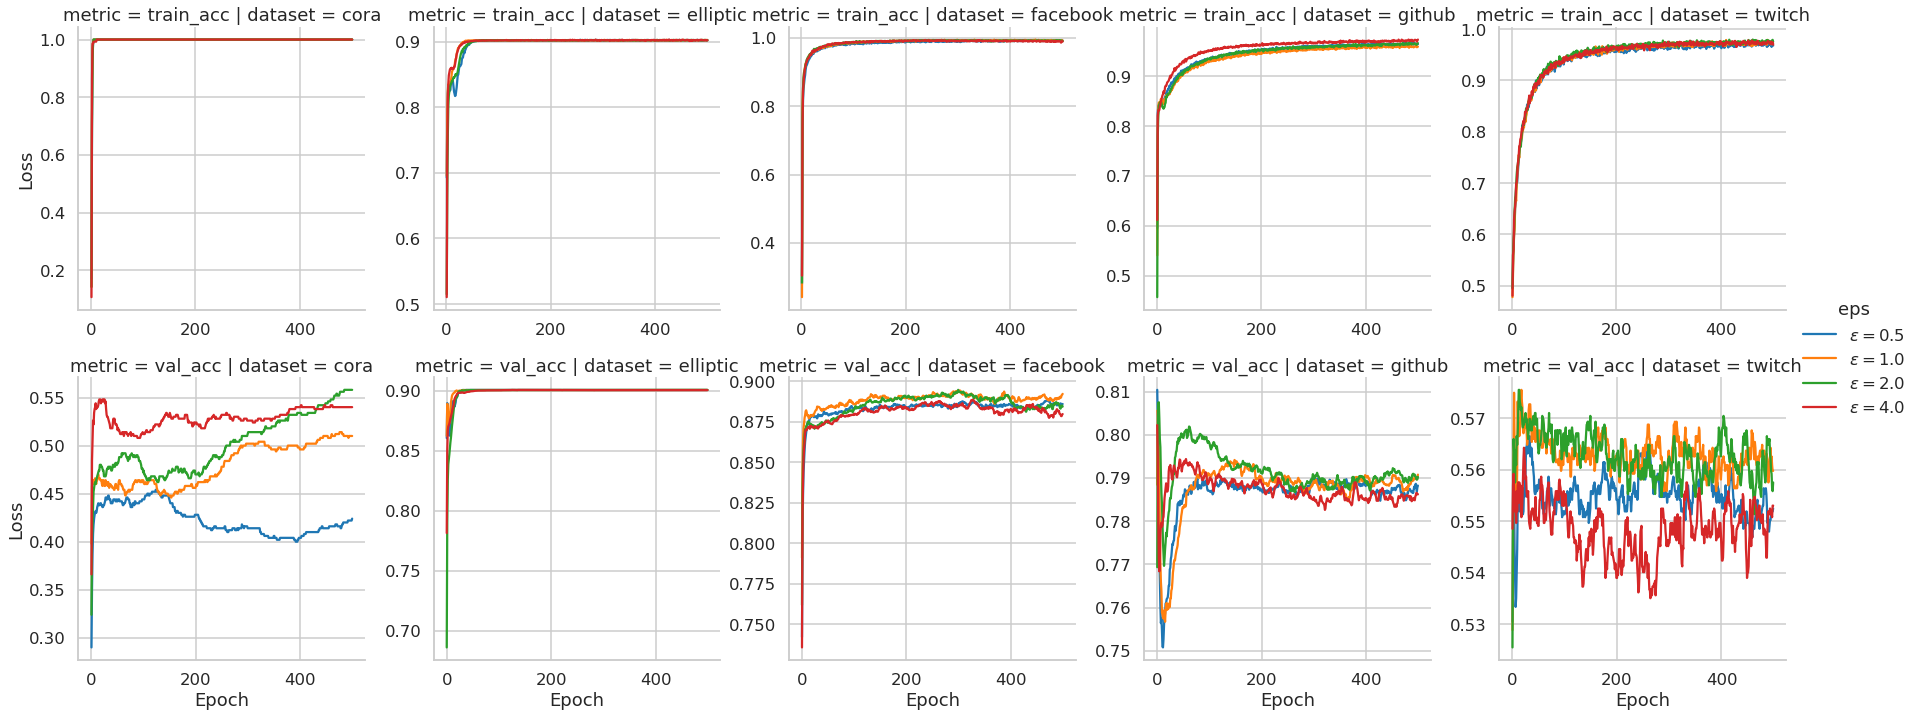

In [8]:
export_figure(path='figures', df=data, x='step', y='value', hue='eps', row='metric', col='dataset', group='task')

data['eps'] = data['eps'].apply(lambda x: f'$\epsilon={x}$')
ax = sns.relplot(
    data=data, kind='line', x='step', y='value', hue='eps', row='metric', col='dataset',
    facet_kws=dict(sharey=False, sharex=False), ci=None
)
ax.set_ylabels('Loss')
ax.set_xlabels('Epoch')

In [11]:
data = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['mbm'], 
    epsilons=[1.0],
    hops=[1, 2, 4],
    aggs=['mean'],
    metrics=['train_acc', 'val_acc']
)

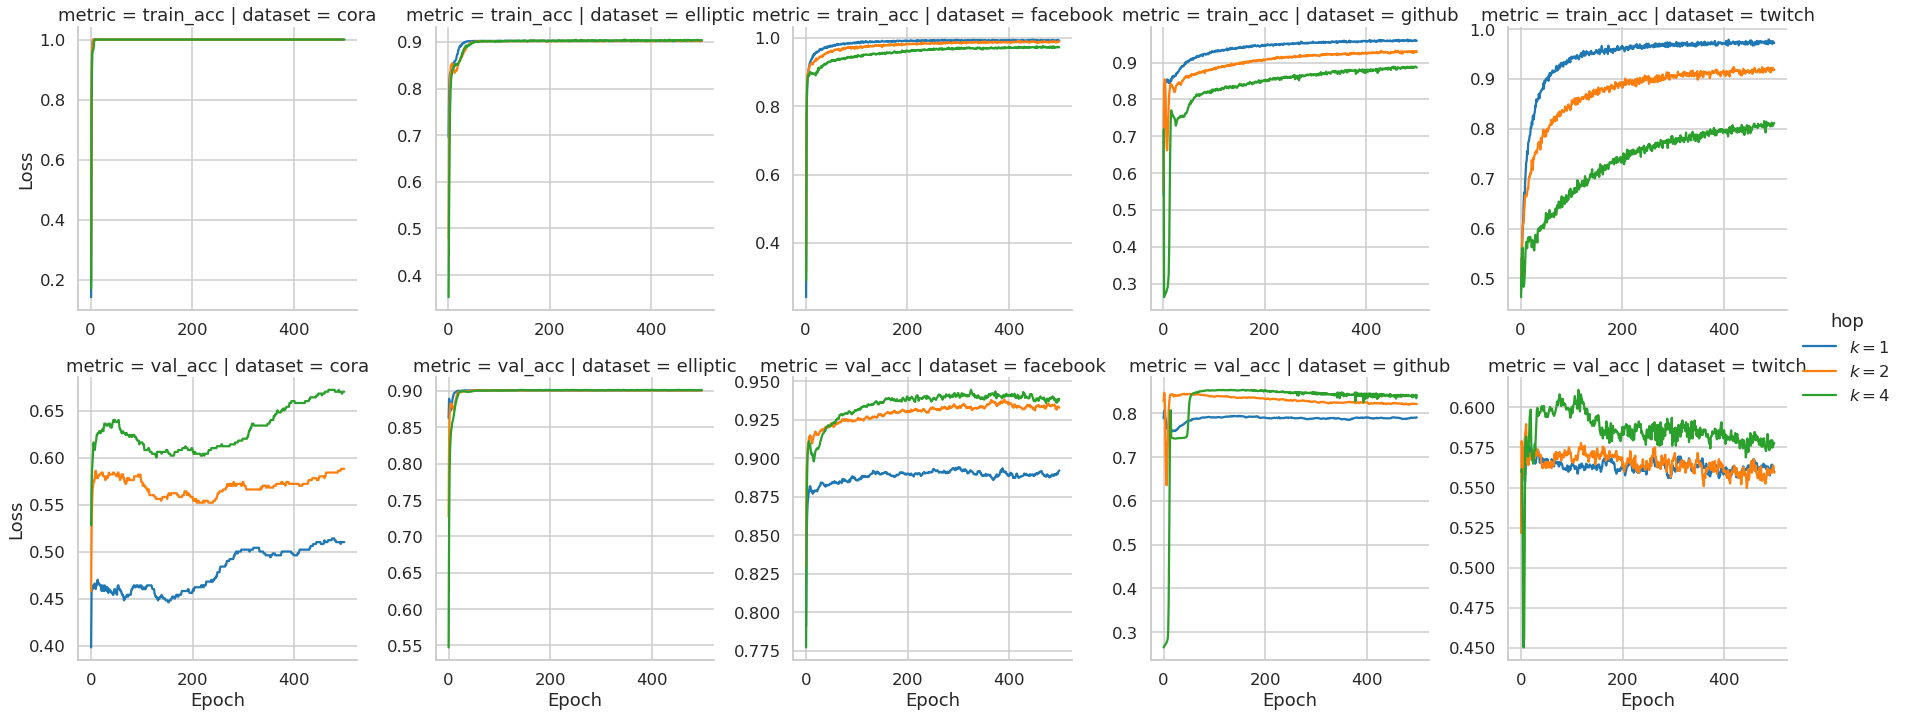

In [12]:
# export_figure(path='figures', df=data, x='step', y='value', hue='hop', row='metric', col='dataset', group='task')

data['hop'] = data['hop'].apply(lambda x: f'$k={x}$')
ax = sns.relplot(
    data=data, kind='line', x='step', y='value', hue='hop', row='metric', col='dataset',
    facet_kws=dict(sharey=False, sharex=False), ci=None
)
ax.set_ylabels('Loss')
ax.set_xlabels('Epoch')

# Testing Pad

In [105]:
data_gcn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['raw'], 
    epsilons=epsilons,
    hops=[1],
    aggs=['gcn'],
    metrics=metrics
)

In [106]:
data_gcn

,task,dataset,method,eps,hop,agg,version,metric,step,value
0,node,cora,raw,0.5,1,gcn,version_0,test_acc,500,0.812000
1,node,cora,raw,1.0,1,gcn,version_0,test_acc,500,0.812000
2,node,cora,raw,2.0,1,gcn,version_0,test_acc,500,0.812000
3,node,cora,raw,4.0,1,gcn,version_0,test_acc,500,0.812000
4,node,cora,raw,0.5,1,gcn,version_1,test_acc,500,0.814000
...,...,...,...,...,...,...,...,...,...,...
195,node,twitch,raw,4.0,1,gcn,version_8,test_acc,500,0.614823
196,node,twitch,raw,0.5,1,gcn,version_9,test_acc,500,0.612016
197,node,twitch,raw,1.0,1,gcn,version_9,test_acc,500,0.612016
198,node,twitch,raw,2.0,1,gcn,version_9,test_acc,500,0.612016


In [97]:
data_dpgnn = read_tensorboard_logs(
    path='results/',
    tasks=['node'],
    datasets=get_available_datasets(), 
    methods=['mbm'], 
    epsilons=epsilons,
    hops=[1,2,4,8,16,32,64],
    aggs=['mean'],
    metrics=metrics
)

In [107]:
data_dpgnn

,task,dataset,method,eps,hop,agg,version,metric,step,value
0,node,cora,mbm,0.5,1,mean,version_0,test_acc,500,0.46800
1,node,cora,mbm,0.5,1,mean,version_1,test_acc,500,0.47100
2,node,cora,mbm,0.5,1,mean,version_2,test_acc,500,0.44900
3,node,cora,mbm,0.5,1,mean,version_3,test_acc,500,0.48300
4,node,cora,mbm,0.5,1,mean,version_4,test_acc,500,0.51000
...,...,...,...,...,...,...,...,...,...,...
1395,node,twitch,mbm,4.0,64,mean,version_5,test_acc,500,0.55306
1396,node,twitch,mbm,4.0,64,mean,version_6,test_acc,500,0.55306
1397,node,twitch,mbm,4.0,64,mean,version_7,test_acc,500,0.55306
1398,node,twitch,mbm,4.0,64,mean,version_8,test_acc,500,0.55306


In [130]:
df_mean = data_dpgnn.groupby(['dataset', 'eps', 'hop'])['value'].mean().reset_index()
df_mean

,dataset,eps,hop,value
0,cora,0.5,1,0.477300
1,cora,0.5,2,0.586300
2,cora,0.5,4,0.665400
3,cora,0.5,8,0.694500
4,cora,0.5,16,0.699000
...,...,...,...,...
135,twitch,4.0,4,0.578327
136,twitch,4.0,8,0.568838
137,twitch,4.0,16,0.558113
138,twitch,4.0,32,0.553397


In [135]:
idx = df_mean.groupby(['dataset', 'eps'])['value'].transform(max) == df_mean['value']
df_max = df_mean[idx]
df_max

,dataset,eps,hop,value
4,cora,0.5,16,0.699000
11,cora,1.0,16,0.700800
20,cora,2.0,64,0.710000
27,cora,4.0,64,0.735000
34,elliptic,0.5,64,0.928168
41,elliptic,1.0,64,0.925797
48,elliptic,2.0,64,0.923546
55,elliptic,4.0,64,0.923598
58,facebook,0.5,4,0.935090
66,facebook,1.0,8,0.938010


In [141]:
df_final = data_dpgnn.merge(df_max.drop(columns='value'), on=['dataset', 'eps', 'hop'], how='inner')
df_final

,task,dataset,method,eps,hop,agg,version,metric,step,value
0,node,cora,mbm,0.5,16,mean,version_0,test_acc,500,0.699000
1,node,cora,mbm,0.5,16,mean,version_1,test_acc,500,0.698000
2,node,cora,mbm,0.5,16,mean,version_2,test_acc,500,0.707000
3,node,cora,mbm,0.5,16,mean,version_3,test_acc,500,0.722000
4,node,cora,mbm,0.5,16,mean,version_4,test_acc,500,0.712000
...,...,...,...,...,...,...,...,...,...,...
195,node,twitch,mbm,4.0,2,mean,version_5,test_acc,500,0.568782
196,node,twitch,mbm,4.0,2,mean,version_6,test_acc,500,0.577765
197,node,twitch,mbm,4.0,2,mean,version_7,test_acc,500,0.586749
198,node,twitch,mbm,4.0,2,mean,version_8,test_acc,500,0.586749
